In [1]:
import pandas as pd
import numpy as np
import os, re, unidecode
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from icecream import ic
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk import RSLPStemmer
from string import punctuation

In [2]:

resenha = pd.read_csv(root + 'Desktop/Scripts/NLP files/imdb-reviews-pt-br.csv')
resenha['sentiment_num'] = resenha['sentiment'].map({'neg':0, 'pos':1})

In [3]:
resenha.head()

,id,text_en,text_pt,sentiment,sentiment_num
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


In [4]:
vetorizar = CountVectorizer(lowercase = False)
texto = ['Assisti um filme bom', 'Assisti um filme ruim']
bow = vetorizar.fit_transform(texto)
sp_matrix = pd.DataFrame.sparse.from_spmatrix(bow, columns = vetorizar.get_feature_names())
sp_matrix

,Assisti,bom,filme,ruim,um
0,1,1,1,0,1
1,1,0,1,1,1


In [5]:
vetorizar = CountVectorizer(lowercase = False, max_features = 50)
texto = resenha['text_pt']
bow = vetorizar.fit_transform(texto)
bow.shape
# sp_matrix = pd.DataFrame.sparse.from_spmatrix(bow, columns = vetorizar.get_feature_names())
# sp_matrix

(49459, 50)

In [6]:
sp_matrix = pd.DataFrame.sparse.from_spmatrix(bow, columns = vetorizar.get_feature_names())
sp_matrix.head()

,Eu,ao,apenas,as,com,como,da,de,do,dos,...,seu,sobre,sua,são,também,tem,tão,um,uma,você
0,0,1,0,0,2,1,0,4,4,2,...,1,1,0,0,0,1,0,3,2,0
1,0,0,0,0,2,0,0,7,1,2,...,1,0,0,2,0,1,0,4,2,1
2,1,0,0,0,3,1,0,10,2,0,...,0,0,0,3,1,0,1,3,2,2
3,2,0,1,4,7,2,1,13,3,1,...,0,0,0,1,0,1,0,7,4,1
4,0,0,1,2,3,0,1,16,2,1,...,0,0,0,4,0,0,0,3,4,0


In [7]:
treino, teste, classe_treino, classe_teste = train_test_split(bow, 
                                                              resenha.sentiment_num,
                                                              random_state = 42)

log_reg = LogisticRegression()
log_reg.fit(treino, classe_treino)
acc = log_reg.score(teste, classe_teste)
ic(acc)

ic| acc: 0.6583097452486858


0.6583097452486858

In [34]:
n = len(classe_teste)
n_try = 100
zero_score_list = []

for i in range(n_try):
    
    zero_score = np.sum(np.random.randint(0, 2, n) == classe_teste)/n
    zero_score_list.append(zero_score)
    
zero_score = np.array(zero_score_list).mean()

print('Acurácia zero:', round(zero_score, 5))

Acurácia zero: 0.49989


In [9]:
def classificar_texto(texto, coluna_texto, coluna_classificacao, max_features = 50):
    vetorizar = CountVectorizer(lowercase = False, max_features = max_features)
    bow = vetorizar.fit_transform(texto[coluna_texto])
    
    treino, teste, classe_treino, classe_teste = train_test_split(bow, 
                                                                  texto[coluna_classificacao],
                                                                  random_state = 42)
    
    log_reg = LogisticRegression()
    log_reg.fit(treino, classe_treino)
    return log_reg.score(teste, classe_teste)

In [10]:
print(classificar_texto(resenha, 'text_pt', 'sentiment_num'))

0.6583097452486858


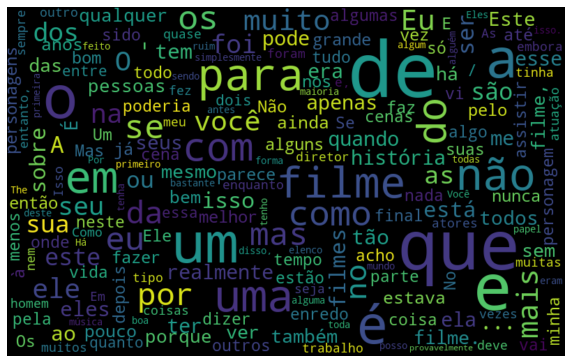

In [11]:
%matplotlib inline

all_words = ' '.join([frase for frase in resenha.text_pt]).split()
freqs = Counter(all_words)

wc = WordCloud(height = 500, width = 800, max_font_size = 110).generate_from_frequencies(freqs)

plt.figure(figsize = (10, 7), frameon = False)
plt.axis('off')
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [12]:
def generate_wordcloud(texto, coluna_texto, coluna_filtro, _filter = None):
    
    if _filter is not None:    
        texto = texto.loc[texto[coluna_filtro] == _filter][coluna_texto]
    else:
        texto = texto[coluna_texto]
        
    all_words = ' '.join([frase for frase in texto]).split()
    freqs = Counter(all_words)

    wc = WordCloud(height = 500, width = 800, max_font_size = 110).generate_from_frequencies(freqs)

    plt.figure(figsize = (10, 7), frameon = False)
    plt.axis('off')
    plt.imshow(wc, interpolation = 'bilinear')
    plt.show()

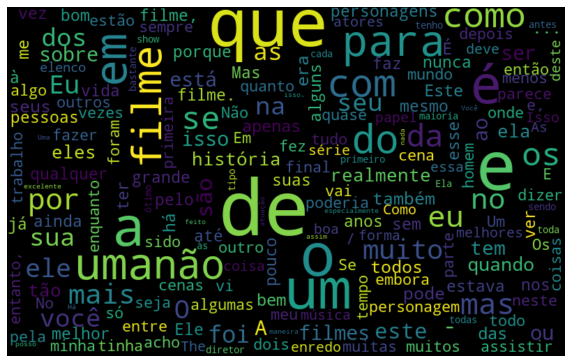

In [13]:
generate_wordcloud(resenha, 'text_pt', 'sentiment_num', 1)

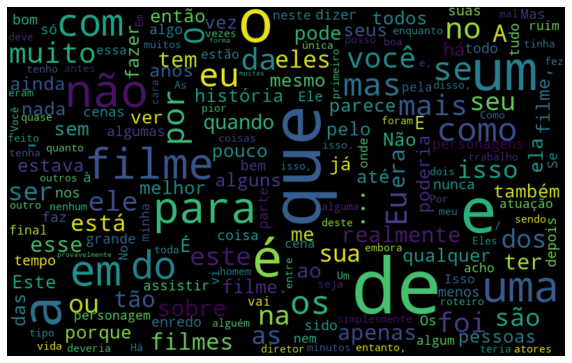

In [14]:
generate_wordcloud(resenha, 'text_pt', 'sentiment_num', 0)

<AxesSubplot:ylabel='Palavras'>

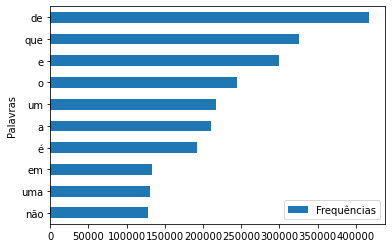

In [15]:
all_words = ' '.join([frase for frase in resenha.text_pt]).split()
freqs = Counter(all_words)

df_freqs = pd.DataFrame()
df_freqs['Palavras'] = freqs.keys()
df_freqs['Frequências'] = freqs.values()

df_freqs.nlargest(columns = 'Frequências', n = 10)[::-1].plot(x = 'Palavras', y = 'Frequências', kind = 'barh', sort_columns = True)

In [16]:
pt_stopwords = stopwords.words('portuguese')
pt_stopwords = [unidecode.unidecode(i) for i in pt_stopwords]
regex_punctuation = '|'.join(['\\' + i for i in punctuation])

resenha['text_pt_no_stop'] = resenha['text_pt'].str.lower() #tudo em minúscula
resenha['text_pt_no_stop'] = resenha['text_pt_no_stop'].apply(lambda x: unidecode.unidecode(x)) #retirada de acentos
resenha['text_pt_no_stop'] = resenha['text_pt_no_stop'].apply(lambda x: ' '.join([i for i in x.split() if i not in pt_stopwords])) #retirada de stopwords
resenha['text_pt_no_stop'] = resenha['text_pt_no_stop'].apply(lambda x: ''.join([re.sub(regex_punctuation, '', i) for i in x])) #retirada de pontuação

In [17]:
resenha.head()

,id,text_en,text_pt,sentiment,sentiment_num,text_pt_no_stop
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,vez sr costner arrumou filme tempo necessario ...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,exemplo motivo maioria filmes acao mesmos gene...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,beatles puderam escrever musicas todos gostass...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,filmes fotos latao palavra apropriada eles ver...


In [18]:
print(classificar_texto(resenha, 'text_pt_no_stop', 'sentiment_num'))

0.6862919530934088


<AxesSubplot:ylabel='Palavras'>

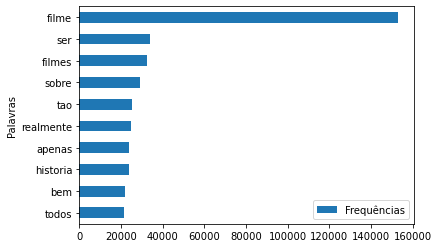

In [19]:
all_words = ' '.join([frase for frase in resenha.text_pt_no_stop]).split()
freqs = Counter(all_words)

df_freqs = pd.DataFrame()
df_freqs['Palavras'] = freqs.keys()
df_freqs['Frequências'] = freqs.values()

df_freqs.nlargest(columns = 'Frequências', n = 10)[::-1].plot(x = 'Palavras', y = 'Frequências', kind = 'barh', sort_columns = True)

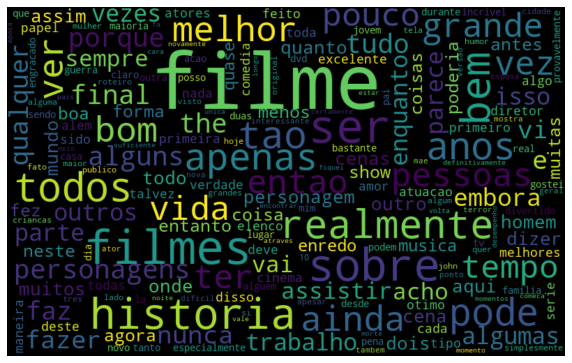

In [20]:
generate_wordcloud(resenha, 'text_pt_no_stop', 'sentiment_num', 1)

In [21]:
stemmer = RSLPStemmer()
resenha['text_pt_no_stop_stemmed'] = resenha['text_pt_no_stop'].apply(lambda x: ' '.join([stemmer.stem(i) for i in x.split()])) #retirada de acentos

In [22]:
resenha.head()

,id,text_en,text_pt,sentiment,sentiment_num,text_pt_no_stop,text_pt_no_stop_stemmed
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,vez sr costner arrumou filme tempo necessario ...,vez sr costn arrum film temp necessari alem te...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,exemplo motivo maioria filmes acao mesmos gene...,exempl motiv maior film aca mesm gener chat na...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,primeiro tudo odeio raps imbecis poderiam agir...,prim tud odei rap imbecil pod agir arm pressio...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,beatles puderam escrever musicas todos gostass...,beatl pud escrev music tod gost emb walt hill ...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,filmes fotos latao palavra apropriada eles ver...,film fot lata palavr apropri ele verdad tant o...


In [23]:
print(classificar_texto(resenha, 'text_pt_no_stop_stemmed', 'sentiment_num'))

0.6959967650626769


<AxesSubplot:ylabel='Palavras'>

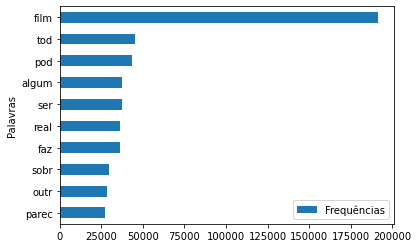

In [24]:
all_words = ' '.join([frase for frase in resenha.text_pt_no_stop_stemmed]).split()
freqs = Counter(all_words)

df_freqs = pd.DataFrame()
df_freqs['Palavras'] = freqs.keys()
df_freqs['Frequências'] = freqs.values()

df_freqs.nlargest(columns = 'Frequências', n = 10)[::-1].plot(x = 'Palavras', y = 'Frequências', kind = 'barh', sort_columns = True)

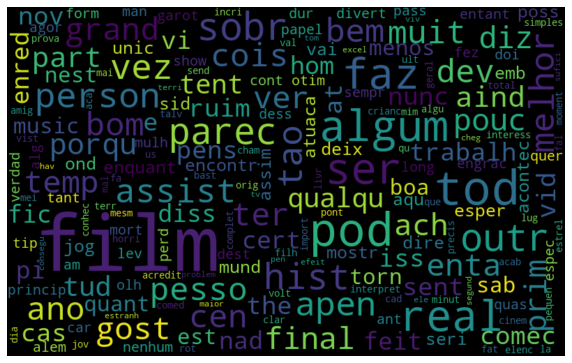

In [25]:
generate_wordcloud(resenha, 'text_pt_no_stop_stemmed', 'sentiment_num')

In [26]:
#Demonstração TF-IDF Vectorizer

frases = ['Assisti um filme ótimo', 'Assisti um filme péssimo']

tfidf = TfidfVectorizer(lowercase = False, max_features = 50)

comps = tfidf.fit_transform(frases)
pd.DataFrame(comps.todense(), columns = tfidf.get_feature_names())

,Assisti,filme,péssimo,um,ótimo
0,0.448321,0.448321,0.000000,0.448321,0.630099
1,0.448321,0.448321,0.630099,0.448321,0.000000


In [27]:
def classificar_texto_tfidf(texto, coluna_texto, coluna_classificacao, max_features = 50):
    vetorizar = TfidfVectorizer(lowercase = False, max_features = max_features)
    tfidf = vetorizar.fit_transform(texto[coluna_texto])
    
    treino, teste, classe_treino, classe_teste = train_test_split(tfidf, 
                                                                  texto[coluna_classificacao],
                                                                  random_state = 42)
    
    log_reg = LogisticRegression()
    log_reg.fit(treino, classe_treino)
    return log_reg.score(teste, classe_teste)

In [28]:
print('Acc textos tratados + bow:', classificar_texto(resenha, 'text_pt_no_stop', 'sentiment_num'))
print('Acc textos tratados + tfidf:', classificar_texto_tfidf(resenha, 'text_pt_no_stop', 'sentiment_num'))
print('Acc textos tratados + stemmer + bow:', classificar_texto(resenha, 'text_pt_no_stop_stemmed', 'sentiment_num'))
print('Acc textos tratados + stemmer + tfidf:', classificar_texto_tfidf(resenha, 'text_pt_no_stop_stemmed', 'sentiment_num'))

Acc textos tratados + bow: 0.6862919530934088
Acc textos tratados + tfidf: 0.6867771936918722
Acc textos tratados + stemmer + bow: 0.6959967650626769
Acc textos tratados + stemmer + tfidf: 0.6984229680549939


In [29]:
def classificar_texto_tfidf_ngrams(texto, coluna_texto, coluna_classificacao, max_features = 50):
    vetorizar = TfidfVectorizer(lowercase = False, max_features = max_features, ngram_range = (1,2))
    tfidf = vetorizar.fit_transform(texto[coluna_texto])
    
    treino, teste, classe_treino, classe_teste = train_test_split(tfidf, 
                                                                  texto[coluna_classificacao],
                                                                  random_state = 42)
    
    log_reg = LogisticRegression()
    log_reg.fit(treino, classe_treino)
    return log_reg.score(teste, classe_teste)

In [30]:
max_f = 200
print('Acc textos tratados + bow:', classificar_texto(resenha, 'text_pt_no_stop', 'sentiment_num', max_features = max_f))
print('Acc textos tratados + tfidf:', classificar_texto_tfidf(resenha, 'text_pt_no_stop', 'sentiment_num', max_features = max_f))
print('Acc textos tratados + tfidf + ngrams:', classificar_texto_tfidf_ngrams(resenha, 'text_pt_no_stop', 'sentiment_num', max_features = max_f))
print('Acc textos tratados + stemmer + bow:', classificar_texto(resenha, 'text_pt_no_stop_stemmed', 'sentiment_num', max_features = max_f))
print('Acc textos tratados + stemmer + tfidf:', classificar_texto_tfidf(resenha, 'text_pt_no_stop_stemmed', 'sentiment_num', max_features = max_f))
print('Acc textos tratados + stemmer + tfidf + ngrams:', classificar_texto_tfidf_ngrams(resenha, 'text_pt_no_stop_stemmed', 'sentiment_num', max_features = max_f))

Acc textos tratados + bow: 0.7792964011322281
Acc textos tratados + tfidf: 0.7809138697937728
Acc textos tratados + tfidf + ngrams: 0.7792155276991508
Acc textos tratados + stemmer + bow: 0.7915891629599676
Acc textos tratados + stemmer + tfidf: 0.7919126566922766
Acc textos tratados + stemmer + tfidf + ngrams: 0.7904569348968864


In [31]:
vetorizar = TfidfVectorizer(lowercase = False, max_features = 100, ngram_range = (1,2))
tfidf = vetorizar.fit_transform(resenha['text_pt_no_stop_stemmed'])

treino, teste, classe_treino, classe_teste = train_test_split(tfidf, 
                                                              resenha['sentiment_num'],
                                                              random_state = 42)

log_reg = LogisticRegression()
log_reg.fit(treino, classe_treino)

LogisticRegression()

In [32]:
pesos = pd.DataFrame(
    log_reg.coef_[0].T,
    index = vetorizar.get_feature_names()
)

pesos.nlargest(10,0)

,0
otim,4.723110
aind,1.868399
vid,1.693585
bem,1.538272
melhor,1.470523
espec,1.461942
gost,1.451823
vi,1.444768
mund,1.392283
vai,1.340340


In [33]:
pesos.nsmallest(10,0)

,0
ruim,-6.660518
pi,-6.120604
nad,-3.561030
nenhum,-3.362604
parec,-2.594277
tent,-2.510808
menos,-2.374497
sid,-1.985269
apen,-1.752871
enred,-1.750791
